# Homework 2 

## Group I

Anna Kurek - 01444623  
Linyun Huang - 01379982  
Mark O'Shea - 01384962  
Mingyang Tham - 01428168  
Rejpal Matharu - 01367169  
Yiting Wang - 01423116

### Question 1

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import operator

The dataset provided contains information on the number of self-reported instances of interactions between individuals in the course, where each individual reported the number of messages sent, and the number of messages received, to each other individual in the course. This structure resulted in 2 tables of data - one for received, one for sent.

It is noticed that both tables contain duplicate data, with one corresponding to the transpose of the other (if Person A reports sending a message to Person B, Person B should report receiving a message from Person A). However, as this survey relies heavily on self-reporting with little information on how to quantify or define an interaction, there were large inconsistencies in the data between both tables. To mitigate this inconsistency, the following analysis will be conducted on the average between the 'Sent' tables and the transpose of the 'Received' table, where a datapoint $X_{i,j}$ is the average between Person $i$'s reported sent messages to Person $j$, and Person $j$'s reported received messages from Person $i$.

In [4]:
dfInteractions = pd.ExcelFile('HW2_who_talks_to_whom.xlsx')
dfSent = dfInteractions.parse(dfInteractions.sheet_names[0]).fillna(0).replace(['-'], [0]).drop('Nodes', 1)
dfReceived = dfInteractions.parse(dfInteractions.sheet_names[1]).fillna(0).replace(['-'], [0]).drop('Nodes', 1)
dfSent.index = dfSent.columns
dfReceived.index = dfReceived.columns

dfAverage = (dfReceived.transpose().add(dfSent, fill_value=0))/2

A directed graph is used to represent this data, as interactions can potentially be one sided, where a message is sent and no reply is received. Furthermore, an additional attribute - 'distance' - is added to each edge for the sake of centrality calculations. This attribute on edge $e_{i,j}$, which we define as $\frac{1}{X_{i,j}}$, proxies the closeness of this one-sided relationship, or how close Person $i$ feels to Person $j$.

In [5]:
a = dfAverage.as_matrix()
G = nx.DiGraph(a)

dist = nx.get_edge_attributes(G, 'weight')
for k,v in dist.items():
    dist[k] = 1/v
nx.set_edge_attributes(G, dist, 'distance')

Using this NetworkX DiGraph, centrality measures were calculated on the basis that a person's influence and importance stems from people talking to them, rather than them talking to people. 

The nodes with the highest values for each centrality measure is found and printed below, along with a graph representation of the network in the cohort. 

   deg  indeg  outdeg  indeg_centr  eigenv  closeness  betweenness
0   32     32      32           32      22         22           22
1   22     22      22           22      62         18           73
2   62     62      62           62      32         45           51
3   37     37      37           37      47         51           18
4   53      4      53            4      31         32           61


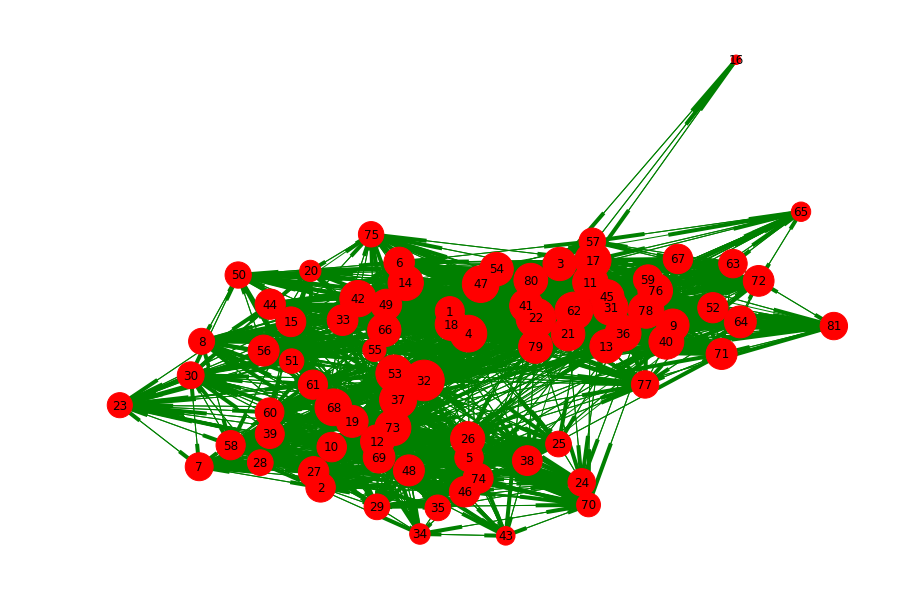

In [33]:
#Creating a DataFrame of numerous centrality measures for each individual
centralitydfAvg = pd.DataFrame(index = list(range(1,82)))
centralitydfAvg['deg'] = (dict(G.degree(weight=None))).values()
centralitydfAvg['indeg'] = (dict(G.in_degree(weight=None))).values()
centralitydfAvg['outdeg'] = (dict(G.out_degree(weight = None))).values()
centralitydfAvg['indeg_centr']=(nx.in_degree_centrality(G)).values()
centralitydfAvg['eigenv']=(nx.eigenvector_centrality(G, max_iter=500)).values() #represents importance based on nodes pointing TO this node
centralitydfAvg['closeness'] = (nx.closeness_centrality(G.reverse(), distance = 'distance')).values() #represents closeness TO this node
centralitydfAvg['betweenness'] = (nx.betweenness_centrality(G, normalized = False, weight = 'distance')).values()

#Finding leaders in each type of centrality
leaders = pd.DataFrame(columns = centralitydfAvg.columns)
for col in leaders:
    leaders[col] = centralitydfAvg[col].nlargest(5).index
print(leaders)

# for clustering coeff we need to create undirected graph
GUnd = nx.Graph(a)
clstringCoeff = nx.clustering(GUnd, weight='weight')
sortedClstringCoeff = sorted(clstringCoeff.items(), key=operator.itemgetter(1))

%matplotlib inline
plt.figure(figsize=(12, 8))
nodesDegree = dict(nx.degree(G))
nodelist = nodesDegree.keys()
nodeSize = [v * 15 for v in nodesDegree.values()]
G = nx.convert_node_labels_to_integers(G, first_label=1) # changes labeling of nodes from 1-81 instead 0-80
nx.draw(G, with_labels=True, node_size = nodeSize, node_color='red', edge_color='green')

The above directed graph illustrates the network of our cohort, with node size representative of the node's degree. Person 32 has the highest number of interactions in both directions of 110, with 54 people sending him/her messages (indegree of 54) and sending 56 people messages (outdegree of 56). Person 22 is also highly popular with interactions in each direction with 52 people. Close runner-ups are Persons 62, 37, 53 and 4, all with degrees over 90. person 37: 46/46. Using this measure, we can conclude that person 32 and 22 are the hubs and are the most popular and influential people in our cohort. 

However, there are other commonly used centrality measures. Eigenvector centrality is based on the concept that a person's importance is derived from the importance of the people talking to them. The individuals with the highest eigenvalues are node 22 (0.177), followed by node 62 (0.167), node 32 (0.163), and node 47 (0.161). 

We used the 'distance' attribute, as defined above, to measure the closeness and betweeness centralities of each individual in the cohort as well. As we defined importance to be derived from people talking to an individual, the reverse of the DiGraph is used to calculate closeness, making closeness the reciprocal of the sum of shortest path distances to this node from all other nodes. Person 22 shows the highest value in this definition of closeness (4.66), followed by nodes 18, 45, 51 and 32. 

In addition, we computed the betweenness centrality to gain more insight about the network. Betweenness centrality of a node is the sum of the fraction of all-pairs shortest paths that pass through this node, where we used the 'distance' attribute to find the shortest paths. The most important node in this measure turned out to be number 22 with value 2375.5, then node 73 with value 1950, node 51 with value 1350, and node 18 with value 1330. However, while this measure does provide insights to the network, it is not as important as the above measures in finding the leaders of the cohort, as it serves more to find the people who link the cohort and bring people together. 

The clustering coefficient is the highest for node 59 (0.0424), 51 (0.0412) and 20 (0.04).

It is clear from the above analysis that the individuals being mentioned often and topping each centrality measure are individuals 22 and 32, making them the most likely leaders and influencers within the cohort. 





### Question 2
#### Part A

In [4]:
import pandas as pd
import gurobipy as grb
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import vincenty

The data provided were the longitudes and latitudes of 38 cities in Djibouti, multiplied by 1000. To begin, we parsed this data into a `pandas` dataframe, and created a new variable, $position$, which is a string representing its GPS coordinates. The variable is then run through the `vincenty` function from `geopy.distance` package to find the distance between each pair of cities in kilometers. 

In [6]:
#read, adjust data
file = open('HW2_tsp.txt', 'r')
file = file.readlines()
data=pd.DataFrame(file[10:])
data.columns=['x']
data=data['x'].str.split(' ',expand=True)
data.columns=['city','latitude','longitude']
data["city"] = pd.to_numeric(data["city"])
data["latitude"] = pd.to_numeric(data["latitude"])/1000
data["longitude"] = pd.to_numeric(data["longitude"])/1000
data['position'] = data['latitude'].astype(str) +','+ data['longitude'].astype(str)

#calculate great circle distance of each pair of the city
distance=list()
for i in range(38):
    for j in range(38):
        distance.append((vincenty(data.loc[i,'position'],data.loc[j,'position']).km))

chunks = [distance[x:x+38] for x in range(0, len(distance), 38)]

#turn into a distance matrix
cities = []
for i in range(1, len(data)+1):
    cities.append('city ' + str(i))
distances = pd.DataFrame(chunks, columns=cities, index=cities)

This distance matrix can then be saved as a NetworkX graph, with cities as nodes and edges weighted by the distances. A plot of the cities based on their coordinates is shown below. 

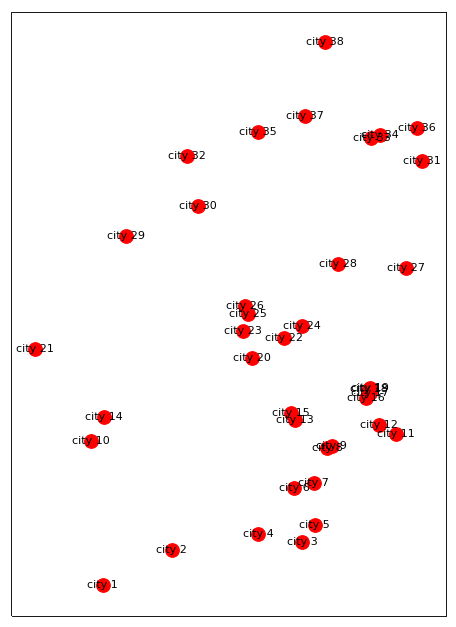

In [7]:
#Create X,Y coordinates of each node
xypos = {}
for i in range(len(data)):
    xypos['city ' + str(data['city'][i])] = ( data['longitude'][i] , data['latitude'][i])

G = nx.from_pandas_adjacency(distances)

#Create plot
plt.clf()
%matplotlib inline
plt.figure(figsize=(7, 10), dpi= 80)
nx.draw_networkx_nodes(G, pos = xypos, node_size=150)
nx.draw_networkx_labels(G, pos = xypos, font_size=10)
plt.xticks([])
plt.yticks([])
plt.show()

#### Part C

To solve the travelling salesperson problem using integer programming, cut constraints have to be added one at a time to ensure the problem does not become too large. To do this, several functions have to first be defined.

Firstly, `saveresult` is a written as a function that takes an optimized result from a Gurobi model that has been solved, and saves it into a NetworkX graph that has only the edges provided by the solution. It accepts an argument `draw`, where the default is `True`, indicating whether or not the NetworkX graph should be drawn. 

Secondly, `findsubtour` is a function that finds every node connected to a starting node (defined as an argument) in a graph, and returns a set of all connected nodes.

Lastly, `addcuttomodel` is a function that takes 3 arguments - a complete graph, a subtour set (set of nodes connected in a subtour) and a Gurobi model. Using the subtour set, it finds every edge in the complete graph that is part of the cut which creates the subtour set. It then adds the cut to the Gurobi model, stating that the sum of all the edges within this cut has to be greater or equal to 2. 

In [8]:
#Definining several functions to use later in a while loop
def saveresult(draw=True):
    """
    To be used after optimizing a Gurobi model.
    Saves the result of a Gurobi Optimizer solution as a Graph, returning NetworkX Graph Object.
    Use draw=True argument to draw the graph.
    """

    vals = m.getAttr('x', vars)
    res=[]
    for i,j in vals.items():
        if j>0:
            res.append(i)
    FG = nx.Graph()
    FG.add_nodes_from(G)
    FG.add_edges_from(res)
    if draw == True:
        nx.draw_networkx(FG, pos=xypos, node_size=150, font_size=10)
    return (FG)

def findsubtour(currentGraph, startnode):
    """
    From a NetworkX Graph, uses BFS to find all nodes linked to a starting node.
    Returns a set that has all nodes which are in the same subtour as the starting node. 
    """
    mainsubtour = set()
    for k,v in dict(nx.bfs_successors(currentGraph, startnode)).items():
        if k not in mainsubtour:
            mainsubtour.add(k)
        for i in v:
            if i not in mainsubtour:
                mainsubtour.add(i)
    return (mainsubtour)

def addcuttomodel(fullgraph, subtourset, Model):
    """
    Identifies the cut (list of edges) that creates the subtour in subtourset.
    Adds a constraint to a Gurobi model specifying that the sum of this subtour >= 2. 
    """
    #Define the cut separating this subtour
    cut = []
    for i,j in fullgraph.edges():
        if i in subtourset and j not in subtourset:
            cut.append((i,j))
        elif j in subtourset and i not in subtourset:
            cut.append((j,i))
    
    #Add cut constraint
    varsx = Model.addVars(cut)
    for i,j in varsx.keys():
        varsx[i,j] = vars[i,j]
    Model.addConstr(varsx.sum() >= 2)

Once these functions are defined, the Gurobi package in Anaconda can be used to solve the travelling salesperson problem for the 38 cities in Djibouti. We first generate the basic model, which only includes the series of constraints indicating that the degree of each node has to be equal to 2. We then solve this first iteration, plot the result and look for subtours. 

In [ ]:
#Generate Gurobi model
m = grb.Model()

#Create variables - edges
edgedict = dict(nx.get_edge_attributes(G, 'weight'))
vars = m.addVars(edgedict.keys(), obj=edgedict, vtype=grb.GRB.BINARY, name='edge')
for i,j in vars.keys():
    vars[j,i] = vars[i,j] # edge in opposite direction is equal and referred to edge

#Add initial constraints: Degree of each node = 2
m.addConstrs(vars.sum(i,'*') == 2 for i in G.nodes())

#First Iteration:
m.optimize()

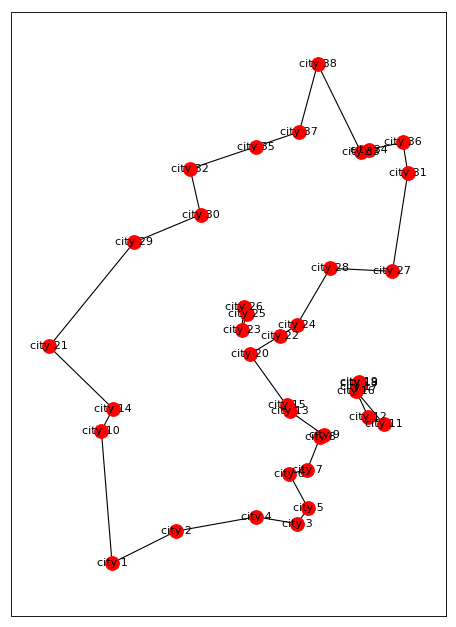

In [10]:
#Create plot
plt.clf()
%matplotlib inline
plt.figure(figsize=(7, 10), dpi= 80)
plt.xticks([])
plt.yticks([])
FG = saveresult(draw=True)

tour = findsubtour(FG, 'city 1')

As subtours are present, we now run a loop that adds a cut constraint to, and then re-optimizes the model. After each optimization, it saves the results and finds a subtour within the result. This loop will repeat until the subtour within the result covers all the nodes, which indicates that the optimal tour has been found. Once this optimal result is achieved, we plot the optimal tour.

In [ ]:
n=1
#Can run each iteration separately to see how the graph changes with each added cut constraint
while len(tour) != len(G.nodes()):
    addcuttomodel(G, tour, m)
    m.optimize()
    n+=1
    FG = saveresult(draw=False)
    tour = findsubtour(FG, 'city 1')

Iterations:  15


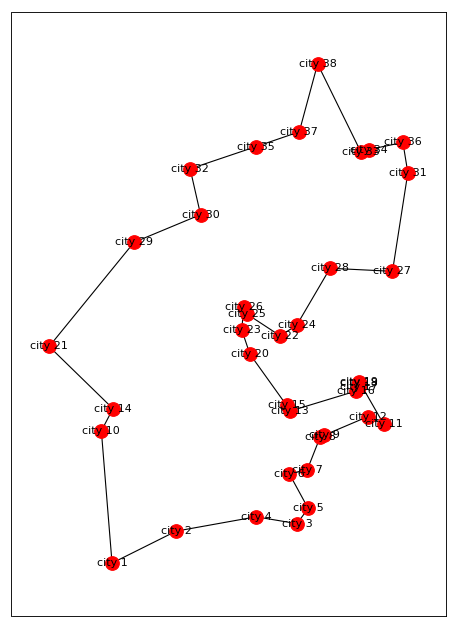

In [64]:
print('Iterations: ', n)

#Create plot
plt.clf()
%matplotlib inline
plt.figure(figsize=(7, 10), dpi= 80)
plt.xticks([])
plt.yticks([])
FG = saveresult(draw=True)

Using this set of functions, 15 iterations were required to find the optimal tour. This means that only 14 cut constraints were added, as opposed to the immensely large number of possible cuts in the graph. The optimal tour that was found takes the route plot above, and has a length of 730.612km.